# TODO
seeding

# Setup
## Variables for configuration

In [32]:
one_hot_encoded_features = ['cp','restecg', 'slope','ca', 'restwm']
# list the datasets that should be used in the current run
datasets = ["hungarian", "cleveland", "switzerland", "long-beach-va"]

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
# set pandas to show all columns of the df when using the display function
pd.set_option('display.max_columns', None)

# Import Data

In [34]:
# custom function to read the dataset into a csv formatted string
# the name is used as a delimiter here because it is the last feature and common among all entrys 
def read_raw_data(file_path:str):
    with open(file_path) as file:
        file_string = file.read()
        # remove unnecessary linebreaks
        file_string = file_string.replace("\n"," ")
        # break lines after name to separate measurements by line (name is a constant and the last attribute)
        file_string = file_string.replace("name ","name\n")
        # separate columns by "," instead of " ".
        file_string = file_string.replace(" ",",")
        return file_string

In [35]:
# read the data from the specified datasets into the df 
from io import StringIO
df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(read_raw_data("./Data/"+ dataset +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    df = pd.concat([df,dataset_df ], ignore_index=True)

In [36]:
df.columns=["id", "ccf", "age", "sex", "painloc", "painexer" , "relrest" , "pncaden" , "cp", "trestbps", "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist", "restecg", "ekgmo", "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic", "proto", "thaldur", "thaltime", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak", "slope", "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref", "exerwm", "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num", "lmt", "ladprox", "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox", "rcadist", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "name", "dataset"]
# Trestbps and trestbpd describe resting blood pressure but are not highly correlated. Therefore, we keep them.

In [37]:
# replace -9 by NaN (according to Data/heart-disease.names)
df.replace(-9,np.float64("NaN"), inplace = True)

In [38]:
# we want to predict whether a patient has any heart disease, not the type/degree of heart disease as recommended by the UCI https://archive.ics.uci.edu/ml/datasets/Heart+Disease
df[df["num"]>1] = 1

# Treatment of different scales in the datasets
the reasons for this processing are laid out further in the analysis notebook
## met

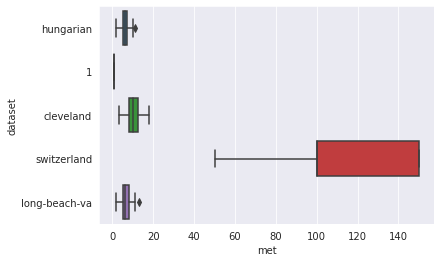

In [39]:
# plot to show the reason why we need to process this data:
sns.boxplot(x="met",y="dataset",data= df)
plt.show()

In [40]:
# the measurements of switzerland do not seem valid -> replace with NaN
df.loc[df["dataset"] == "switzerland", "met"] = np.float64("NaN")

### rldv5e

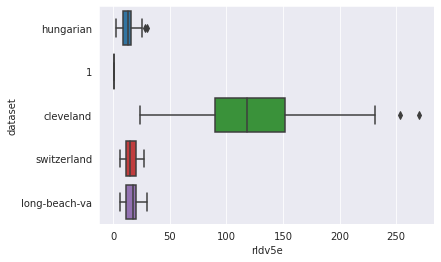

In [41]:
# plot to show the reason why we need to process this data: 
sns.boxplot(x="rldv5e",y="dataset",data= df)
plt.show()

In [42]:
# the measurements of cleveland do not seem valid -> replace with NaN
df.loc[df["dataset"] == "cleveland", "rldv5e"] = np.float64("NaN")

# Drop columns

In [43]:
irrelevant_columns = [
    "id", # A id is not relevant for a model
    "ccf", # the social security number does not influence if you have a heart disease or not
    "pncaden", # sum of painlox painexer relrest -> the features are already in the dataset -> drop because it is a duplicate
    "ekgmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "name" # Constant
]
df.drop(irrelevant_columns, inplace=True, axis=1)

In [44]:
unexplained_columns = [
    "restckm", # irrelevant according to the uci
    "exerckm", # irrelevant according to the uci
    "thalsev", # irrelevant according to the uci
    "thalpul", # irrelevant according to the uci
    "earlobe", # Constant
    "lvx1", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx2", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx3", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx4", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvf", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "dummy", # no description available -> from the name does not seem relevant
    'junk'
]
df.drop(unexplained_columns, inplace=True, axis=1)

In [45]:
hidden_identifier = [
    'lmt',      # Left main truck
    'ladprox',  # Proximal left anterior descending artery
    'laddist',  # Distal left anterior descending artery
    'diag',     # Diagonal branches
    'cxmain',   # Circumflex
    'ramus',    # Ramus intermedius
    'om1',      # First obtuse marginal branch
    'om2',      # Second obtuse marginal branch
    'rcaprox',  # Proximal right coronary artery
    'rcadist',  # Distal right coronary artery
]
df.drop(hidden_identifier, inplace=True, axis=1)

# Train the different models

In [46]:
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from  sklearn.naive_bayes import *

estimators=[
    {"estimator": XGBClassifier(random_state=42, n_jobs=1), "parameters": {}},
                                    # 'estimator__max_depth': [None] + [2,6,10,20,50,100],
                                    # 'estimator__n_estimators': range(10,1000, 100),           Not enough time and heuristics of XGBoost are very good
                                    # 'estimator__learning_rate':[0.001,0.01,0.1,0.2,0.3]}
    {"estimator": SVC(random_state=42, tol=0.01), "parameters": {'estimator__C': [120,130,140,160],
                                                                 'estimator__gamma': [0.0001, 0.001, 0.01],
                                                                 'estimator__kernel':['linear', 'rbf', 'poly', 'sigmoid'] }},
    {"estimator": BernoulliNB(), "parameters": {'estimator__alpha' : np.arange(0,20,0.1)}},
    {"estimator": CategoricalNB(), "parameters": {'estimator__alpha' : np.arange(0,20,0.1)}},
    {"estimator": ComplementNB(), "parameters": {'estimator__alpha' : np.arange(0,20,0.1),
                                                 'estimator__norm':[True,False]}},
    {"estimator": GaussianNB(), "parameters": {}},
    {"estimator": MultinomialNB(), "parameters": {'estimator__alpha' : np.arange(0,20,0.1)}},
    {"estimator": DecisionTreeClassifier(random_state=42), "parameters": {'estimator__criterion':['gini','entropy'],
                                                                          'estimator__max_depth':[None,2,6,10],
                                                                          'estimator__min_samples_split': range(2,11,4)}},
    {"estimator": KNeighborsClassifier(), "parameters": {'estimator__n_neighbors': range(2, 100,5),
                                                         'estimator__weights': ['uniform','distance'],
                                                         'estimator__p': [1,2]}},
    {"estimator": RandomForestClassifier(random_state=42, n_jobs=1), "parameters": {'estimator__n_estimators':range(10,100, 10),
                                                                                    'estimator__max_depth':[None,2,6,10],
                                                                                    'estimator__min_samples_split': range(2,11,4)
                                                                                   }},
    {"estimator": LogisticRegression(solver='liblinear'), "parameters": {'estimator__penalty':['l1','l2']}}
    # {"estimator": SGDClassifier(max_iter=100000), "parameters": {'estimator__loss':['log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    #                                               'estimator__penalty':['l1','l2','elasticnet'],
    #                                               'estimator__alpha' : np.arange(1,40,5)}}
]

In [47]:
from sklearn.preprocessing import *
scalers = [
    {"scaler": MaxAbsScaler(), "parameters": {}},
    {"scaler": MinMaxScaler(), "parameters": {}},
    {"scaler": Normalizer(), "parameters": {'scaler__norm': ['l1', 'l2', 'max']}},
    {"scaler": PowerTransformer(), "parameters": {}},
    {"scaler": RobustScaler(), "parameters": {}},
    {"scaler": StandardScaler(), "parameters": {}},
    {"scaler": 'passthrough', "parameters": {}}
]

In [48]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
imputers = [
    {"imputer": SimpleImputer(), "parameters": {'impute__strategy' : ['mean', 'median', 'most_frequent']}},
    # KNN imputer is not used after inspection of the runtime with the KNN classifier (see KNN_classifier_with_KNN_and_simple_imputer.json)
    # {"imputer": KNNImputer(), "parameters": {'impute__n_neighbors': range(2, 10,1)}},
    # iterative imputer is not used because bugs were observed during the usage of this experimental feature
]

In [49]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
samplers = ['passthrough', RandomOverSampler(random_state=42),RandomUnderSampler(random_state=42)]

In [50]:
from sklearn.compose import ColumnTransformer
general_parameters = {
    #values are selected based on analysis in Analyse.ipynb
    'drop_columns__minimum_percentage_to_be_dropped': [0,4,8,20,35,60,75,100],
    'oneHotEncoder__discretize':[
        'passthrough',
        KBinsDiscretizer(2,encode='ordinal', strategy='uniform'),
        KBinsDiscretizer(5,encode='ordinal', strategy='uniform')]
}

The columns smoke, cigs and years describe whether a respondent smokes or not. Smoke does this by being binary coded, while years describes the number of years a person has smoked. Cigs describes how many cigarettes the person smokes a day. Due to the high number of missing values in smoke, it is enriched with the years and cigs columns.

In [51]:
class DataframeSmokeTransformer:
    def transform(self, input_df, **transform_params):
        # we do not enrich smoke if cigs and years are conflicting

        # set all values of smoke that are NaN to 0 if the value of years is 0 and smoke does not indicate that the person smokes
        input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] == 0) & ~(input_df['cigs'] > 0),'smoke'] = 0
        # set all values of smoke that are NaN to 1 if the value of years is larger than 0 and smoke does not indicate that the person does not smoke
        input_df.loc[(input_df['smoke'].isna()) & (input_df['years'] > 0) & (input_df['cigs'] != 0),'smoke'] = 1

        # set all values of smoke that are NaN to 0 if the value of smoke is 0 and years does not indicate that the person smokes
        input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] == 0) & ~(input_df['years'] > 0),'smoke'] = 0
        # set all values of smoke that are NaN to 1 if the value of cigs is larger than 0 and years does not indicate that the person does not smoke
        input_df.loc[(input_df['smoke'].isna()) & (input_df['cigs'] > 0) & (input_df['years'] != 0),'smoke'] = 1
        return input_df
    def fit(self, X, y=None, **fit_params):
        # there is nothing to be fitted here because this handling is not split specific
        return self

In [52]:
class EnrichHeartRate:
    def transform(self, input_df, **transform_params):
        input_df["heart_rate_diff"] = input_df['thalach'] - input_df['thalrest']
        return input_df

    def fit(self, X, y=None, **fit_params):
        return self

In [53]:
from sklearn.exceptions import NotFittedError
class DropColumnsBasedOnMinimumPercentageToBeDropped:
    def __init__(self):
        self.minimum_percentage_to_be_dropped = 100
        self.fitted = False
        self.valuesToKeep = []

    def set_params(self, **params):
        self.minimum_percentage_to_be_dropped = params.get('minimum_percentage_to_be_dropped')

    def transform(self, input_df, **transform_params):
        if self.fitted:
            return input_df[input_df.columns.intersection(self.valuesToKeep)]
        else:
            raise NotFittedError()

    def fit(self, X, y=None, **fit_params):
        # calculate percentage of missing values for each column and store in a dictionary
        percentage_missing = (X.isna().sum()/len(df)*100).to_dict()
        # generate list of columns to keep
        self.valuesToKeep = [key for key, val in percentage_missing.items() if val <= self.minimum_percentage_to_be_dropped]
        self.fitted = True
        return self

In [54]:
class FixCommonEncodingErrors:
    def transform(self, input_df, **transform_params):
        input_df = input_df.copy(deep=True)
        # if cholesterin is 0 it was not measured
        input_df.loc[input_df['chol'] == 0,'chol'] =  np.float64("NaN")
        # leave the dead ones behind
        # drop entries with a blood pressure of 0
        input_df.loc[input_df['trestbps'] == 0,'trestbps'] =  np.float64("NaN")
        # is a binary variable (wrong measurement was detected in Pandas Profiling Report)
        input_df.loc[df['prop'].isin([0,1]) == False,'prop' ] = np.float64("NaN")
        # is a variable that has the values 0-3 by definition  (wrong measurement was detected in Pandas Profiling Report)
        input_df.loc[input_df['ca'] >3 ,'ca'] =  np.float64("NaN")
        # transform proto according to possible values from data/ask-detrano
        input_df.loc[input_df['proto'] == 200,'proto'] =  9
        input_df.loc[input_df['proto'] == 175,'proto'] =  8
        input_df.loc[input_df['proto'] == 150,'proto'] =  7
        input_df.loc[input_df['proto'] == 130,'proto'] =  6
        input_df.loc[input_df['proto'] == 125,'proto'] =  5
        input_df.loc[input_df['proto'] == 100,'proto'] = 4
        input_df.loc[input_df['proto'] == 75,'proto'] = 3
        input_df.loc[input_df['proto'] == 50,'proto'] = 2
        input_df.loc[input_df['proto'] == 50,'proto'] = 1
        #set all other values to NaN
        input_df.loc[input_df['proto'].isin([*range(1,13)]) == False, 'proto'] = np.float64("NaN")

        return input_df
    def fit(self, X, y=None, **fit_params):
        return self

In [55]:
# assumption the dictionaries are of equal structure
def merge_dict(dict1, dict2):
    for key, val in dict1.items():
        # merge nested dictionaries
        if type(val) == dict:
            dict1[key] = merge_dict(dict1[key], dict2[key])
        # if value of dict1 is a list -> append values of dict2[key] to that list
        elif type(val) == list:
            if type(dict2[key]) == list:
                dict1[key] = [ *dict1[key], *dict2[key]]
            else:
                dict1[key] = [*dict1[key], dict2[key]]
        else:
            # merge values into a new list
            dict1[key] = [val, dict2[key]]

    return dict1

In [56]:
import pickle
import os
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_auc_score

# It is necessary to write a separate score function to obtain and save results from the respective cross validations later on (outer loop of nested cv).
# This procedure requires working with pickle, as it is not possible to interact with data structures from the notebook (even if they are marked as global), as make_scorer later creates a deepCopy of this function and thus the data structures are also copied. The same applies to the parameters that could be passed to this function in the makeScorer function.
def classification_report_with_auc_score(y_true, y_pred):
    # calculate the score that will be returned to the cross validation to obtain the optimal hyperparameters
    current_roc_auc_score = roc_auc_score(y_true, y_pred)
    #transform confusion matrix to dictionary
    confusion_matrix_dict = {}
    for idxRow, row in np.ndenumerate(confusion_matrix(y_true, y_pred)):
        confusion_matrix_dict[str(idxRow)] = row
    # check if pickle was created by another cross validation loop
    if os.path.exists('temp.pickle'):
        with open("temp.pickle", "rb") as temp_file:
            # read pickled dictionary of previous cross validation loop
            report = pickle.load(temp_file)
            # append current score
            report["auc"].append(current_roc_auc_score)
            # merge classification reports
            report['classification_report'] = merge_dict(report['classification_report'], classification_report(y_true, y_pred, output_dict=True))
            # merge confusion matrix dictionaries
            report['confusion_matrix'] = merge_dict(report['confusion_matrix'], confusion_matrix_dict)
    else:
        #create dictionary for first pickle
        report = {'classification_report': classification_report(y_true, y_pred, output_dict=True),
                  "auc": [current_roc_auc_score],
                  'confusion_matrix': confusion_matrix_dict
                  }
    # write report dictionary to pickle-file
    with open('temp.pickle', 'wb') as temp_file:
        pickle.dump(report, temp_file, protocol=pickle.HIGHEST_PROTOCOL)
    # return calculated roc_auc_score for evaluation in cross validation
    return current_roc_auc_score

In [57]:
from typing import Callable
from imblearn.base import BaseSampler
import json

#custom Encoder for serialization of output
class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if type(obj) == range:
            return [*obj]
        if isinstance(obj, BaseSampler):
            return obj.__class__.__name__
        if isinstance(obj, KBinsDiscretizer):
            return obj.get_params()
        if isinstance(obj, ColumnTransformer):
            return obj.get_params()
        return super(CustomEncoder, self).default(obj)

In [58]:
from imblearn.over_sampling import RandomOverSampler
import time
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer

# separate features from target variable
X = df.loc[:,(df.columns!= 'num') & (df.columns != 'dataset') ].copy(deep=True)
y = df.loc[: , (df.columns== 'num')].values.ravel().copy()

# We would like to be able to analyse the influence of scalers, estimators, imputers and samplers on the score. Therefore, we refrain from using them as hyperparameters. Instead, we loop over all possible configurations and create separate pipelines that are logged separately in the output. In the later analysis, the parameters can still be considered as hyperparamters, but they do not have to be, thus allowing a more detailed analysis. In order to make the results comparable the cross validations and estimators etc. are seeded if possible.
for scaler in scalers:
    for estimator in estimators:
        for imputer in imputers:
            for sampler in samplers:

                # combine the parameter dictionaries (| is a valid operator because the keys do not overlap)
                parameters =  scaler.get("parameters") | estimator.get("parameters") | imputer.get('parameters') | general_parameters
                # use column transformer to oneHotEncode features. Because some categorical values have very few occurences, it could happen, that features are not present in the train set but only in test. This would lead to an error if these categories would not be ignored. The columns that are oneHotEncoded are defined at runtime by the given lambda because it could happen that a column that should be oneHotEncoded was dropped in an earlier pipeline step. Because not all features are processed, the remainders are passed through instead of being dropped (default behaviour).
                oneHotEncoder = ColumnTransformer(
                    transformers=[
                            ('discretize', KBinsDiscretizer(), ['age']),
                            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), lambda X : [value for value in one_hot_encoded_features if value in X.columns]),
                        ], remainder='passthrough')
                #build the pipeline
                pipeline = Pipeline(steps=[
                    ('fix_encoding_errors', FixCommonEncodingErrors()),
                    ('transform_smoke', DataframeSmokeTransformer()),
                    #('enrich_heart_rate', EnrichHeartRate()),
                    ('drop_columns', DropColumnsBasedOnMinimumPercentageToBeDropped()),
                    ('oneHotEncoder', oneHotEncoder),
                    ('impute', imputer.get('imputer')),
                    ('scaler', scaler.get('scaler')),
                    ('sampler', sampler),
                    ('estimator', estimator.get("estimator"))
                ])
                # create the inner grid search instance. No need for random_state because for integer values for cv stratified k-fold is used with shuffle=False(see:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV parameter cv)
                grid_search_estimator = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=10, error_score='raise', n_jobs=-1, verbose= 0)
                # if a configuration fails it is skipped and a comment is placed in the output
                try:
                    print(f"GridSearch for {scaler.get('scaler').__class__.__name__}, {estimator.get('estimator').__class__.__name__},{estimator.get('imputer').__class__.__name__} and {sampler.__class__.__name__}")
                    startTime = time.time()
                    # Start nested cross validation. No need for random_state because for integer values for cv stratified k-fold is used with shuffle=False(see:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html parameter cv)
                    auc_best = cross_val_score(grid_search_estimator, X, y, cv=10, scoring=make_scorer(classification_report_with_auc_score), error_score='raise', verbose = 2, n_jobs=1)
                    # determine best hyperparameters
                    grid_search_estimator.fit(X, y)
                    executionTime = (time.time() - startTime)
                except Exception as e:
                    # add comment for failed execution to output_dict
                    print(f"Skipping the combination of {scaler.get('scaler').__class__.__name__}, {estimator.get('estimator').__class__.__name__},{estimator.get('imputer').__class__.__name__} and {sampler.__class__.__name__} because:")
                    print(str(e))
                    output_dict = {}
                    output_dict["scaler"]= scaler.get('scaler').__class__.__name__
                    output_dict["estimator"] = estimator.get('estimator').__class__.__name__
                    output_dict["imputer"] = imputer.get('imputer').__class__.__name__
                    output_dict["sampler"] = sampler.__class__.__name__
                    output_dict["reason"] = str(e)
                else:
                    # execution was successful. Print results and best configuration
                    print(f"auc for {scaler.get('scaler').__class__.__name__}, {estimator.get('estimator').__class__.__name__},{estimator.get('imputer').__class__.__name__} and {sampler.__class__.__name__} = {auc_best.mean() * 100.0}")
                    display(grid_search_estimator.best_params_)
                    # create output_dict
                    output_dict = {}
                    output_dict["scaler"]= scaler.get('scaler').__class__.__name__
                    output_dict["estimator"] = estimator.get('estimator').__class__.__name__
                    output_dict["imputer"] = imputer.get('imputer').__class__.__name__
                    output_dict["sampler"] = sampler.__class__.__name__
                    output_dict["X_shape"] = X.shape
                    output_dict["one_hot_encoded_features"] = one_hot_encoded_features
                    output_dict["parameters"] = parameters
                    output_dict["auc_mean"] = auc_best.mean() * 100
                    output_dict["execution_time_in_seconds"] = executionTime
                    output_dict["best_params"] = grid_search_estimator.best_params_
                    # read results of outer loop from cv from pickle and add to output dictionary
                    with open("temp.pickle", "rb") as temp_file:
                        report = pickle.load(temp_file)
                        output_dict["auc"] = report['auc']
                        output_dict["classification_report"] = report['classification_report']
                        output_dict["confusion_matrix"] = report['confusion_matrix']
                finally:
                    # read measurements from output.json if it exists, otherwise create empty list
                    if os.path.exists('output.json'):
                        with open("output.json", "r") as file:
                            file_dict = json.load(file)
                            measurements  = file_dict.get('measurements')
                    else:
                        measurements = []
                    # append new measurements to array
                    measurements.append(output_dict)
                    # write to output.json using CustomEncoder
                    with open("output.json", "w") as file:
                        json.dump({"measurements": measurements}, file, cls= CustomEncoder)
                    # remove temp.pickle if it exists
                    if os.path.exists('temp.pickle'):
                        os.remove('temp.pickle')



        print("-----------------------------------------------------------------")

GridSearch for MaxAbsScaler, LogisticRegression,NoneType and str


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/scipy/__init__.py:146

[CV] END .................................................... total time=  60.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   60.0s remaining:    0.0s


[CV] END .................................................... total time=  41.3s
[CV] END .................................................... total time=  56.6s
[CV] END .................................................... total time=  40.9s
[CV] END .................................................... total time=  41.2s
[CV] END .................................................... total time=  41.2s
[CV] END .................................................... total time=  41.2s
[CV] END .................................................... total time=  40.9s
[CV] END .................................................... total time=  39.2s
[CV] END .................................................... total time=  40.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.4min finished


auc for MaxAbsScaler, LogisticRegression,NoneType and str = 83.53761821801893


{'drop_columns__minimum_percentage_to_be_dropped': 60,
 'estimator__penalty': 'l2',
 'impute__strategy': 'mean',
 'oneHotEncoder__discretize': KBinsDiscretizer(encode='ordinal', n_bins=2, strategy='uniform')}

GridSearch for MaxAbsScaler, LogisticRegression,NoneType and RandomOverSampler


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  42.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.4s remaining:    0.0s


[CV] END .................................................... total time=  43.0s
[CV] END .................................................... total time=  42.3s
[CV] END .................................................... total time=  42.0s
[CV] END .................................................... total time=  43.2s
[CV] END .................................................... total time=  43.0s
[CV] END .................................................... total time=  36.5s
[CV] END .................................................... total time=  35.3s
[CV] END .................................................... total time=  35.8s
[CV] END .................................................... total time=  35.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.6min finished


auc for MaxAbsScaler, LogisticRegression,NoneType and RandomOverSampler = 83.97640617222498


{'drop_columns__minimum_percentage_to_be_dropped': 60,
 'estimator__penalty': 'l2',
 'impute__strategy': 'mean',
 'oneHotEncoder__discretize': KBinsDiscretizer(encode='ordinal', n_bins=2, strategy='uniform')}

GridSearch for MaxAbsScaler, LogisticRegression,NoneType and RandomUnderSampler


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  34.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.7s remaining:    0.0s


[CV] END .................................................... total time=  34.5s
[CV] END .................................................... total time=  33.8s
[CV] END .................................................... total time=  35.1s
[CV] END .................................................... total time=  33.9s
[CV] END .................................................... total time=  34.0s
[CV] END .................................................... total time=  34.1s
[CV] END .................................................... total time=  33.6s
[CV] END .................................................... total time=  34.4s
[CV] END .................................................... total time=  38.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.8min finished


auc for MaxAbsScaler, LogisticRegression,NoneType and RandomUnderSampler = 83.30548780487807


{'drop_columns__minimum_percentage_to_be_dropped': 60,
 'estimator__penalty': 'l2',
 'impute__strategy': 'mean',
 'oneHotEncoder__discretize': KBinsDiscretizer(encode='ordinal', n_bins=2, strategy='uniform')}

-----------------------------------------------------------------
GridSearch for MinMaxScaler, LogisticRegression,NoneType and str


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  34.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.2s remaining:    0.0s


[CV] END .................................................... total time=  34.1s
[CV] END .................................................... total time=  33.4s
[CV] END .................................................... total time=  33.8s
[CV] END .................................................... total time=  33.4s
[CV] END .................................................... total time=  32.4s
[CV] END .................................................... total time=  33.3s
[CV] END .................................................... total time=  33.3s
[CV] END .................................................... total time=  32.9s
[CV] END .................................................... total time=  33.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.6min finished


auc for MinMaxScaler, LogisticRegression,NoneType and str = 83.5355774016924


{'drop_columns__minimum_percentage_to_be_dropped': 60,
 'estimator__penalty': 'l2',
 'impute__strategy': 'mean',
 'oneHotEncoder__discretize': KBinsDiscretizer(encode='ordinal', strategy='uniform')}

GridSearch for MinMaxScaler, LogisticRegression,NoneType and RandomOverSampler


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  35.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.7s remaining:    0.0s


[CV] END .................................................... total time=  35.4s
[CV] END .................................................... total time=  34.8s
[CV] END .................................................... total time=  34.9s
[CV] END .................................................... total time=  35.8s
[CV] END .................................................... total time=  35.5s
[CV] END .................................................... total time=  35.7s
[CV] END .................................................... total time=  34.3s
[CV] END .................................................... total time=  33.6s
[CV] END .................................................... total time=  35.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.8min finished


auc for MinMaxScaler, LogisticRegression,NoneType and RandomOverSampler = 84.69631657541065


{'drop_columns__minimum_percentage_to_be_dropped': 60,
 'estimator__penalty': 'l2',
 'impute__strategy': 'mean',
 'oneHotEncoder__discretize': KBinsDiscretizer(encode='ordinal', n_bins=2, strategy='uniform')}

GridSearch for MinMaxScaler, LogisticRegression,NoneType and RandomUnderSampler


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  34.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.5s remaining:    0.0s


[CV] END .................................................... total time=  32.7s
[CV] END .................................................... total time=  34.4s
[CV] END .................................................... total time=  33.4s
[CV] END .................................................... total time=  34.3s
[CV] END .................................................... total time=  34.6s
[CV] END .................................................... total time=  34.9s
[CV] END .................................................... total time=  33.1s
[CV] END .................................................... total time=  33.7s
[CV] END .................................................... total time=  33.6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.7min finished


auc for MinMaxScaler, LogisticRegression,NoneType and RandomUnderSampler = 82.95853658536586


{'drop_columns__minimum_percentage_to_be_dropped': 60,
 'estimator__penalty': 'l2',
 'impute__strategy': 'mean',
 'oneHotEncoder__discretize': KBinsDiscretizer(encode='ordinal', n_bins=2, strategy='uniform')}

-----------------------------------------------------------------
GridSearch for Normalizer, LogisticRegression,NoneType and str


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 1.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] END .................................................... total time= 1.7min
[CV] END .................................................... total time= 1.7min


/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................................................... total time= 1.7min
[CV] END .................................................... total time= 1.6min
[CV] END .................................................... total time= 1.7min
[CV] END .................................................... total time= 1.6min
[CV] END .................................................... total time= 1.6min
[CV] END .................................................... total time= 1.6min


/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................................................... total time= 1.7min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 16.5min finished


auc for Normalizer, LogisticRegression,NoneType and str = 81.75579890492783


{'drop_columns__minimum_percentage_to_be_dropped': 0,
 'estimator__penalty': 'l1',
 'impute__strategy': 'mean',
 'oneHotEncoder__discretize': KBinsDiscretizer(encode='ordinal', strategy='uniform'),
 'scaler__norm': 'max'}

GridSearch for Normalizer, LogisticRegression,NoneType and RandomOverSampler


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................................................... total time= 1.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] END .................................................... total time= 1.8min
[CV] END .................................................... total time= 1.7min


/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................................................... total time= 1.7min


/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................................................... total time= 1.7min


/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/finn/miniconda

[CV] END .................................................... total time= 1.7min


/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................................................... total time= 1.7min


/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................................................... total time= 2.0min


/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................................................... total time= 2.1min


/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................................................... total time= 2.2min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 18.4min finished


auc for Normalizer, LogisticRegression,NoneType and RandomOverSampler = 81.64053011448482


{'drop_columns__minimum_percentage_to_be_dropped': 0,
 'estimator__penalty': 'l1',
 'impute__strategy': 'mean',
 'oneHotEncoder__discretize': KBinsDiscretizer(encode='ordinal', strategy='uniform'),
 'scaler__norm': 'max'}

GridSearch for Normalizer, LogisticRegression,NoneType and RandomUnderSampler


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 2.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV] END .................................................... total time=31.1min
[CV] END .................................................... total time= 1.8min


/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................................................... total time= 1.7min
[CV] END .................................................... total time= 1.7min


/home/finn/miniconda3/envs/DataMining/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................................................... total time= 1.7min
[CV] END .................................................... total time= 1.7min
[CV] END .................................................... total time= 1.7min
[CV] END .................................................... total time= 1.7min


KeyboardInterrupt: 